# Принцип работы сверточных нейронных сетей

In [248]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Свертка представляет постоянно умножение участка данных на одни и те же веса. Математические это записывают так:
$$h = w \otimes x$$

$w$ - вектор весов 

$x$ - вектор данных (размер намного больше, чем $w$)

$h$ - результат свертки

Но мало кто поясняет как устроена эта самая операция математически. Градиент в конечном итоге считается только для простых операций (функции: sin, cos, e, и операции: +, -, *, /). Поэтому нужно представить эту операцию как что-то простое над вектором весов $w$ и данными $x$.

Пусть свертка представима в виде $$ w \otimes x = \overline{W} x$$

Тогда $\overline{W}$ для $w=(w_0, w_1, w_2)$ и при $len(x) = 4$ выглядит следующим образом



$$\overline{W} = \begin{pmatrix} w_1 & w_0 & 0 & 0 \\ 
                   w_2 & w_1 & w_0 & 0\\
                   0 & w_2 & w_1 & w_0 \\
                   0 & 0 & w_2 & w_1 \end{pmatrix}$$

Вопрос как его получить из простых операций над $w$. Тут нам могут очень пригодиться тензоры

$$E_1 \cdot w =  \begin{pmatrix} 0 & 1 & 0 \\ 
                  0 & 0 & 1 \\
                  0 & 0 & 0 \\
                  0 & 0 & 0\end{pmatrix}  \begin{pmatrix}  w_0 \\ w_1 \\ w_2 \end{pmatrix}   = \begin{pmatrix}  w_1 \\ w_2 \\ 0 \\ 0 \end{pmatrix}$$

$$ E_2 \cdot w = \begin{pmatrix} 1 & 0 & 0 \\ 
                  0 & 1 & 0 \\
                  0 & 0 & 1 \\
                  0 & 0 & 0 \end{pmatrix}  \begin{pmatrix}  w_0 \\ w_1 \\ w_2 \end{pmatrix}   = \begin{pmatrix}  w_0 \\ w_1 \\ w_2 \\ 0 \end{pmatrix}$$

$$ E_3 \cdot w = \begin{pmatrix} 0 & 0 & 0 \\ 
                  1 & 0 & 0 \\
                  0 & 1 & 0 \\
                  0 & 0 & 1 \end{pmatrix}  \begin{pmatrix}  w_0 \\ w_1 \\ w_2 \end{pmatrix}   = \begin{pmatrix}  0 \\ w_0 \\ w_1 \\ w_2 \end{pmatrix}$$

$$ E_4 \cdot w =  \begin{pmatrix} 0 & 0 & 0 \\ 
                  0 & 0 & 0 \\
                  1 & 0 & 0 \\
                  0 & 1 & 0 \end{pmatrix}  \begin{pmatrix}  w_0 \\ w_1 \\ w_2 \end{pmatrix}   = \begin{pmatrix}  0 \\ 0 \\ w_0 \\ w_1 \end{pmatrix}$$

$$[E_1, E_2, E_3, E_4]_{4\times 4 \times 3} \cdot w_{3 \times 1} = \overline{W}_{4 \times 4 \times 1}$$

Хорошо, что добавление и снятие незначимых размерностей, для tf считается элементарной операцией.

In [249]:
# Алгоритм преобразования
@tf.function
def get_mtrx_W(W, size):
    W_size = W.shape[0]
    W_center = W_size // 2
    E = np.zeros((size, size, W_size))
    for i in range(size):
        for j in range(W_size):
            ki = i + j - W_center
            kj =  j 
            if ki < size and ki >= 0 and kj < W_size and kj >= 0:
                E[i, ki, kj] = 1
    
    E = tf.constant(E, dtype=tf.float32)
    return tf.squeeze(tf.matmul(E, tf.reshape(W, (-1, 1))))
    

In [250]:
class cnn(tf.Module):
    def __init__(self, size_ker, size):
        self.W =  tf.Variable(np.zeros((size_ker)), dtype=tf.float32)
        self.size = size
        

    @tf.function
    def __call__(self, x):
        oW = get_mtrx_W(self.W, self.size)
        vec_x = tf.reshape(x, (-1, 1))
        oWx = tf.matmul(oW, vec_x)
        return tf.squeeze(oWx)

@tf.function
def loss(x, x_true):
    return tf.reduce_sum(tf.pow(x-x_true, 2))

Поставим задачу, подобрать такую свертку, чтоб удалить шум из графика

In [258]:
x_sin =  4*np.sin(np.linspace(0, 10*np.pi, 100))
x = x_sin+np.random.random(100)

x_nois = tf.constant(x, dtype=tf.float32)
x_true = tf.constant(x_sin, dtype=tf.float32)

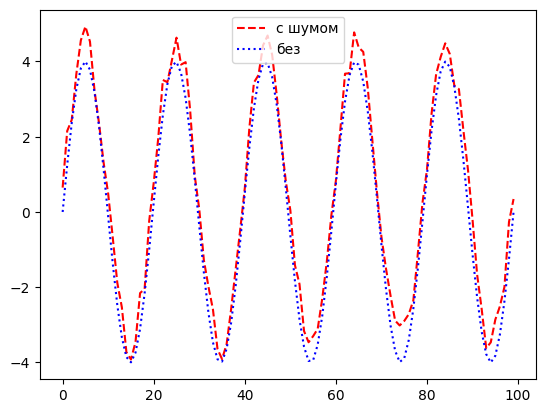

In [262]:
plt.plot(x_nois, 'r--')
plt.plot(x_true, 'b:')
plt.legend(['с шумом','без'])

In [263]:
model = cnn(20, 100)

In [264]:
for epoch in range(100):
    with tf.GradientTape() as tape:
        error = loss(model(x_nois), x_true)
        dy = tape.gradient(error, model.variables)
    model.variables[0].assign_sub(0.00005*dy[0])
    print(epoch, f"{error.numpy()}")

0 792.0
1 70.83984375
2 13.759546279907227
3 9.138433456420898
4 8.67579460144043
5 8.55238151550293
6 8.464742660522461
7 8.387718200683594
8 8.318340301513672
9 8.255524635314941
10 8.198436737060547
11 8.146373748779297
12 8.09871768951416
13 8.054936408996582
14 8.014562606811523
15 7.977189064025879
16 7.942464828491211
17 7.910083293914795
18 7.87977409362793
19 7.851306915283203
20 7.82447624206543
21 7.7991042137146
22 7.775036811828613
23 7.752138137817383
24 7.730290412902832
25 7.709388256072998
26 7.6893463134765625
27 7.670076370239258
28 7.651515483856201
29 7.633599758148193
30 7.616274833679199
31 7.599494934082031
32 7.583216667175293
33 7.567400932312012
34 7.5520195960998535
35 7.537040710449219
36 7.522436618804932
37 7.508187770843506
38 7.494270324707031
39 7.480668544769287
40 7.46736478805542
41 7.454345703125
42 7.441591262817383
43 7.429098606109619
44 7.416850566864014
45 7.404837608337402
46 7.3930511474609375
47 7.38148307800293
48 7.370125770568848
49 7.35

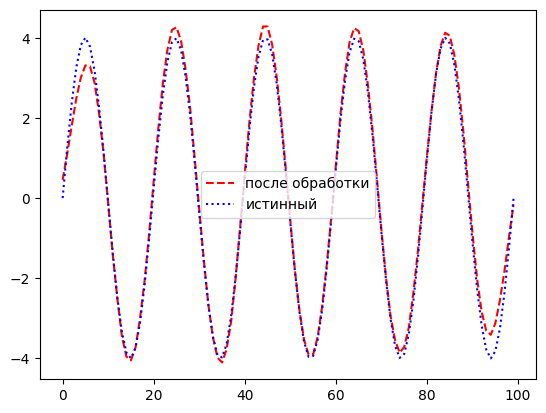

In [266]:
plt.plot(model(x_nois), 'r--')
plt.plot(x_true, 'b:')
plt.legend(['после обработки','истинный'])

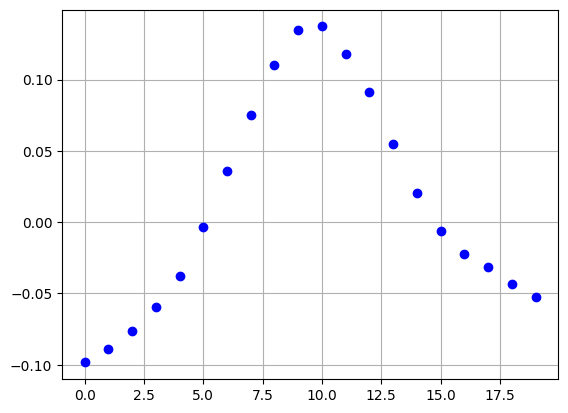

In [267]:
# Вид свертки
plt.plot(model.variables[0], 'bo')
plt.grid()